In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector

In [2]:
db = mysql.connector.connect(host = "localhost",
                            username = "root",
                            password = "Sujin@1029",
                            database = "ecommerce")

cur = db.cursor()

## Total Orders

In [93]:
query=""" select round(sum(payment_value),2)
         from payments; """

cur.execute(query)

data=cur.fetchall()

data[0][0]

16008872.12

## Total Revenue

In [6]:
query = """ select count(order_id) as total_orders
         from orders; """

cur.execute(query)

data=cur.fetchall()

data[0][0]

99441

In [5]:
query = """ select round(count(distinct order_id) * 1.0 / count(distinct customer_id), 2) as avg_orders_per_customer
         from orders; """

cur.execute(query)

data=cur.fetchall()

data[0][0]

Decimal('1.00')

## Average number of orders per unique customer

In [91]:
query = """ select round(count(distinct order_id) * 1.0 / count(distinct customer_id), 2) as avg_orders_per_customer
         from orders; """

cur.execute(query)

data=cur.fetchall()

data[0][0]

Decimal('1.00')

# Order Processing Analysis

## Total number of orders per year/month

In [5]:
query= """select year(order_purchase_timestamp) as year,count(order_id) as total_orders
        from orders
        group by year(order_purchase_timestamp)
        order by year;"""

cur.execute(query)

data=cur.fetchall()

df=pd.DataFrame(data,columns=["Year","Total_Sales"])

df

,Year,Total_Sales
0,2016,329
1,2017,45101
2,2018,54011


In [16]:
query=""" select year(order_purchase_timestamp) as year,month(order_purchase_timestamp) as month,count(order_id) as total_orders
        from orders
        group by year(order_purchase_timestamp),month(order_purchase_timestamp)
        order by year,month;"""

cur.execute(query)

data=cur.fetchall()

df=pd.DataFrame(data,columns=["Year","Month","Tota_Orders"])

df

,Year,Month,Tota_Orders
0,2016,9,4
1,2016,10,324
2,2016,12,1
3,2017,1,800
4,2017,2,1780
5,2017,3,2682
6,2017,4,2404
7,2017,5,3700
8,2017,6,3245
9,2017,7,4026


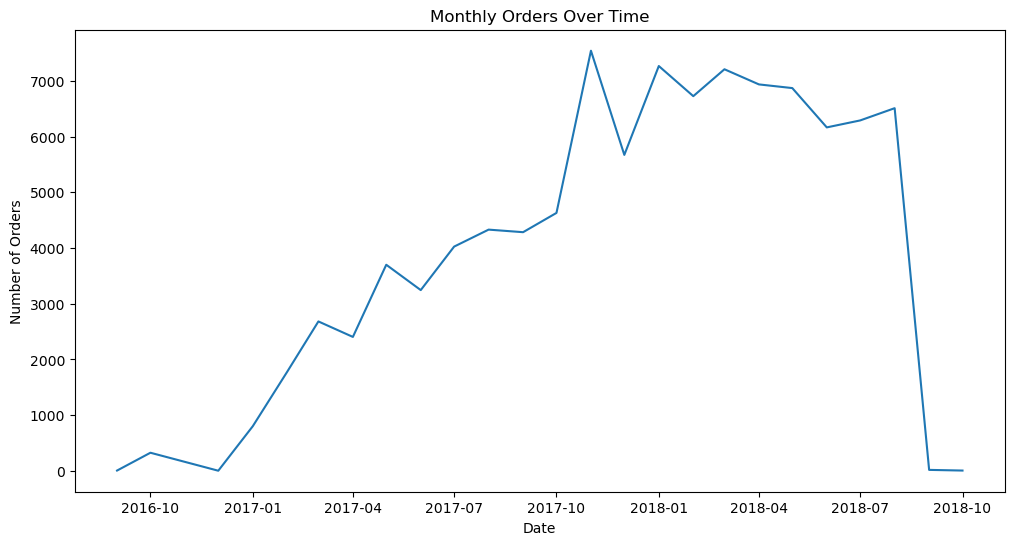

In [17]:
df["Date"]=pd.to_datetime(df["Year"].astype(str)+"-"+df["Month"].astype(str)+"-"+"01")

plt.figure(figsize=(12,6))
plt.plot(df["Date"],df["Tota_Orders"],)
plt.title('Monthly Orders Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Orders')
plt.show()

## Most common order statuses

In [18]:
query=""" select order_status,count(*) as total
        from orders
        group by order_status
        order by total; """

cur.execute(query)

data=cur.fetchall()

df=pd.DataFrame(data,columns=["Order_Status","Total_Orders"])

df

,Order_Status,Total_Orders
0,approved,2
1,created,5
2,processing,301
3,invoiced,314
4,unavailable,609
5,canceled,625
6,shipped,1107
7,delivered,96478


## Average Delivery Time

In [19]:
query=""" select round(avg(datediff(order_delivered_customer_date,order_purchase_timestamp)),2) as average_delivery_days
        from orders
        where order_status  = 'delivered'; """

cur.execute(query)

data=cur.fetchall()

df=pd.DataFrame(data,columns=["Average Delivery Days"])

df

,Average Delivery Days
0,12.50


## Accuracy of estimated delivery dates

In [70]:
query=""" with cte as (select order_id,
        case 
         when order_delivered_customer_date <= order_estimated_delivery_date then "on time"
         when order_delivered_customer_date > order_estimated_delivery_date then "late"
        end as delivery_status
        from orders
        where order_status = 'delivered'
        and order_delivered_customer_date is not null
        and order_estimated_delivery_date is not null)
        select delivery_status,count(*) as total_orders
        from cte
        group by delivery_status
        order by total_orders; """

cur.execute(query)

data=cur.fetchall()

df=pd.DataFrame(data,columns = ["Delivery_Status","Tota_Orders"])

df

,Delivery_Status,Tota_Orders
0,late,7826
1,on time,88644


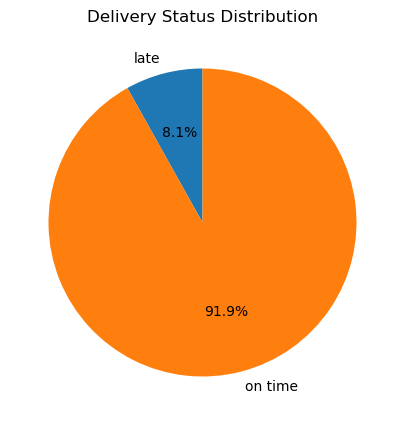

In [73]:
plt.figure(figsize=(5, 5))
plt.pie(df["Tota_Orders"],labels=df["Delivery_Status"],autopct='%1.1f%%',startangle=90)
plt.title('Delivery Status Distribution')
plt.show()

## Percentage of orders delivered late by region/state

In [23]:
query=""" select c.customer_state,
        sum(case when order_delivered_customer_date > order_estimated_delivery_date then 1 end) as late_delivery,
        count(*) as total_delivered,
        round(sum(case when order_delivered_customer_date > order_estimated_delivery_date then 1 end) * 100.0/count(*)) as late_delivery_percentage
        from orders as o
        join customers as c on o.customer_id = c.customer_id
        where o.order_status = 'delivered'
        and o.order_delivered_customer_date is not null
        and o.order_estimated_delivery_date is not null
        group by c.customer_state
        order by late_delivery_percentage desc; """

cur.execute(query)

data=cur.fetchall()

df=pd.DataFrame(data,columns = ["Customer_State","Late_delivery","Total_delivery","Late_Delivery_Percentage"])

df

,Customer_State,Late_delivery,Total_delivery,Late_Delivery_Percentage
0,AL,95,397,24
1,MA,141,717,20
2,PI,76,476,16
3,CE,196,1279,15
4,SE,51,335,15
5,BA,457,3256,14
6,RJ,1664,12350,13
7,TO,35,274,13
8,ES,244,1995,12
9,MS,81,701,12


## States or cities with the highest delivery delays

In [28]:
df[df["Late_Delivery_Percentage"]>10]

,Customer_State,Late_delivery,Total_delivery,Late_Delivery_Percentage
0,AL,95,397,24
1,MA,141,717,20
2,PI,76,476,16
3,CE,196,1279,15
4,SE,51,335,15
5,BA,457,3256,14
6,RJ,1664,12350,13
7,TO,35,274,13
8,ES,244,1995,12
9,MS,81,701,12


# Pricing & Revenue Strategy Analysis

## Average price per product category

In [39]:
query=""" select p.product_category,round(avg(price),2) as average_price
        from Products as p
        join order_items as o on p.product_id  = o.product_id
        group by p.product_category
        order by average_price desc;"""

cur.execute(query)

data=cur.fetchall()

df=pd.DataFrame(data,columns = ["Product_Category","Average_Price"])

df

,Product_Category,Average_Price
0,PCs,1098.34
1,HOUSE PASTALS OVEN AND CAFE,624.29
2,ELECTRICES 2,476.12
3,Agro Industria e Comercio,342.12
4,musical instruments,281.62
...,...,...
69,Drink foods,54.60
70,cds music dvds,52.14
71,Hygiene diapers,40.19
72,flowers,33.64


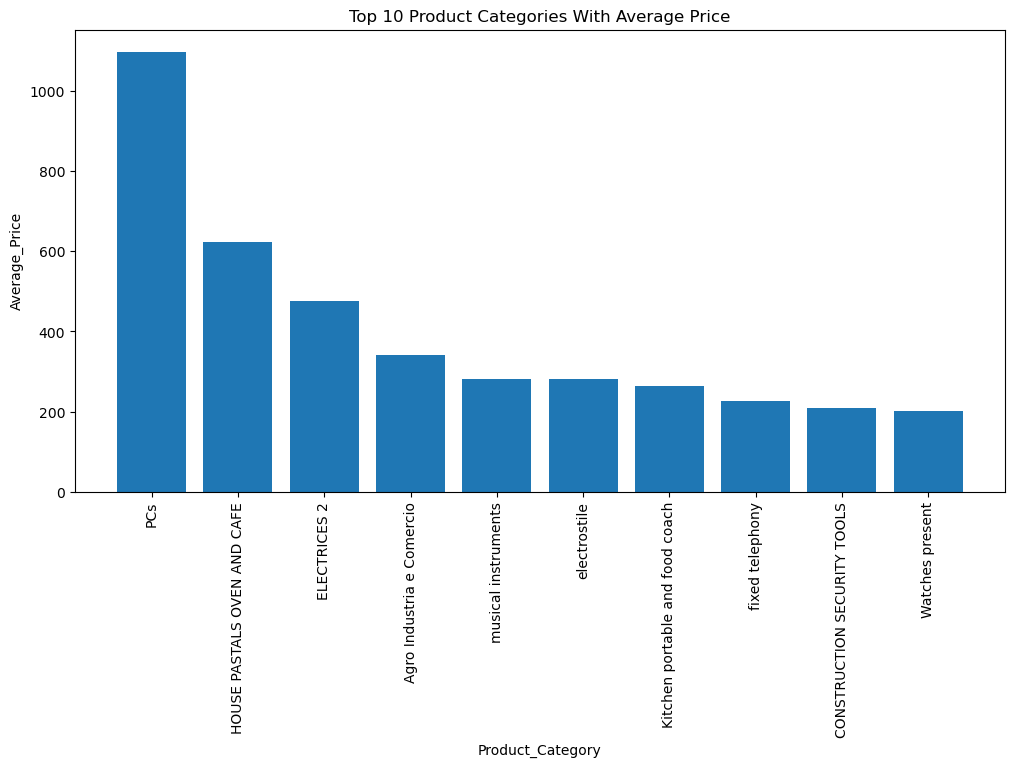

In [40]:
df=df.head(10)

plt.figure(figsize=(12,6))
plt.bar(df["Product_Category"],df["Average_Price"])
plt.title('Top 10 Product Categories With Average Price')
plt.xlabel('Product_Category')
plt.xticks(rotation=90)
plt.ylabel('Average_Price')
plt.show()

## Total revenue generated by product category?

In [41]:
query=""" select p.product_category,round(sum(price),2) as total_price
        from Products as p
        join order_items as o on p.product_id  = o.product_id
        group by p.product_category
        order by total_price desc;"""

cur.execute(query)

data=cur.fetchall()

df=pd.DataFrame(data,columns = ["Product_Category","Total_Price"])

df

,Product_Category,Total_Price
0,HEALTH BEAUTY,1258681.34
1,Watches present,1205005.68
2,bed table bath,1036988.68
3,sport leisure,988048.97
4,computer accessories,911954.32
...,...,...
69,flowers,1110.04
70,House Comfort 2,760.27
71,cds music dvds,730.00
72,Fashion Children's Clothing,569.85


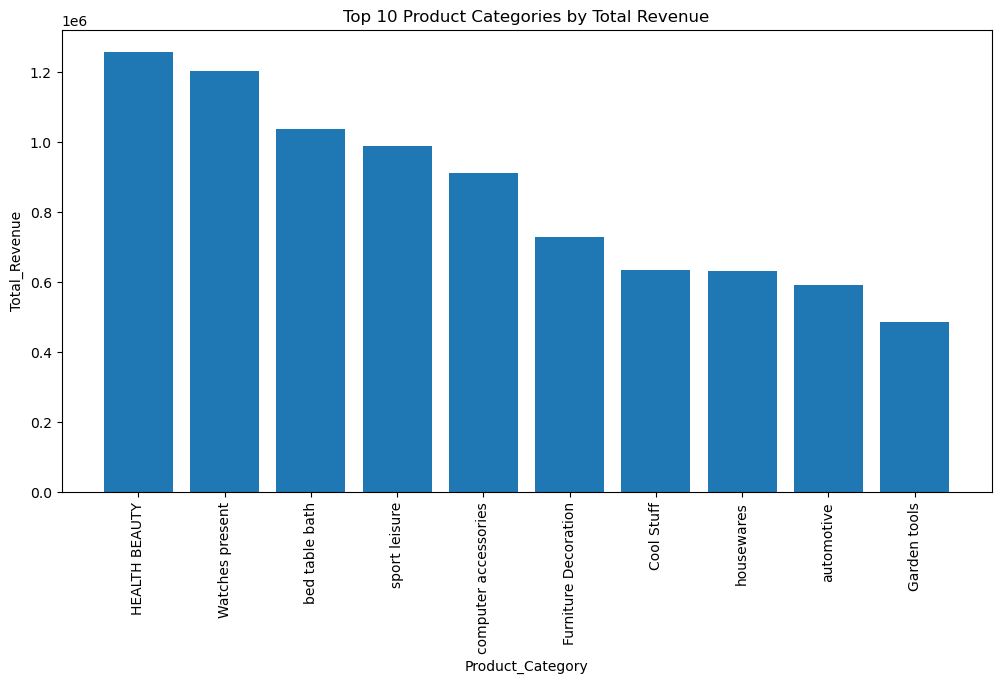

In [42]:
df=df.head(10)

plt.figure(figsize=(12,6))
plt.bar(df["Product_Category"],df["Total_Price"])
plt.title('Top 10 Product Categories by Total Revenue')
plt.xlabel('Product_Category')
plt.xticks(rotation=90)
plt.ylabel('Total_Revenue')
plt.show()

## Average freight (shipping) value per product category

In [45]:
query=""" select p.product_category,round(avg(o.freight_value),2) as average_freight
        from Products as p
        join order_items as o on p.product_id  = o.product_id
        group by p.product_category
        order by average_freight desc; """

cur.execute(query)

data=cur.fetchall()

df=pd.DataFrame(data,columns=["Product_Category","Average_Freight_Cost"])

df

,Product_Category,Average_Freight_Cost
0,PCs,48.45
1,ELECTRICES 2,44.54
2,CITTE AND UPHACK FURNITURE,42.91
3,Furniture Kitchen Service Area Dinner and Garden,42.70
4,Furniture,42.50
...,...,...
69,foods,14.26
70,House Comfort 2,13.68
71,Fashion Women's Clothing,12.95
72,Imported books,12.83


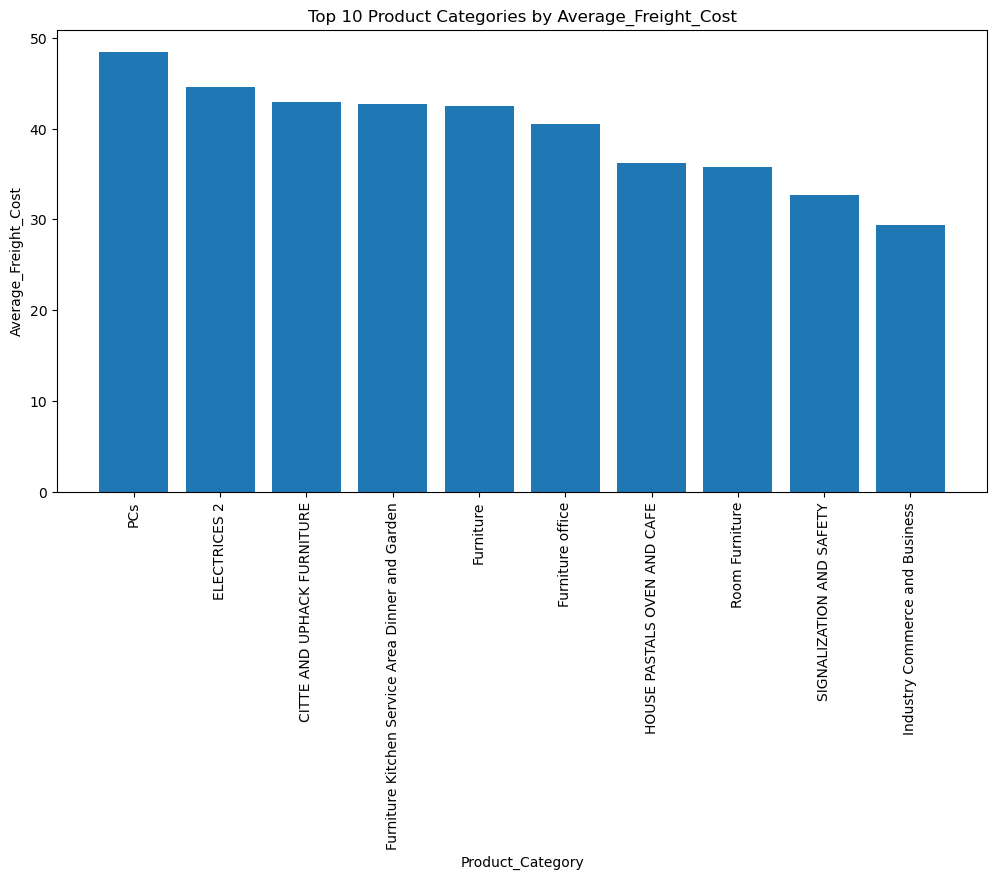

In [46]:
df=df.head(10)

plt.figure(figsize=(12,6))
plt.bar(df["Product_Category"],df["Average_Freight_Cost"])
plt.title('Top 10 Product Categories by Average_Freight_Cost')
plt.xlabel('Product_Category')
plt.xticks(rotation=90)
plt.ylabel('Average_Freight_Cost')
plt.show()

## Product price vs Freight value

In [74]:
query=""" select case 
                when price<50 then "<50"
                when price between 50 and 100 then "50-100"
                when price between 100 and 200 then "100-200"
                when price between 200 and 500 then "200-500"
                else ">500" 
                end as price_range,
        count(*) as total_orders,round(avg(price),2) as avg_price,round(avg(freight_value),2) as avg_freight,
        round(round(avg(freight_value),2)*100.0/round(avg(price),2),2) as freight_percentage
        from order_items
        group by price_range
        order by case
                  when price_range = "<50" then 1
                  when price_range = "50-100" then 2
                  when price_range = "100-200" then 3
                  when price_range = "200-500" then 4
                  else 5 
                  end; """

cur.execute(query)

data=cur.fetchall()

df=pd.DataFrame(data,columns=["Price_Range","Total_Orders","Avg_Price","Avg_Freight","Freight_Percentage"])

df

,Price_Range,Total_Orders,Avg_Price,Avg_Freight,Freight_Percentage
0,<50,39024,31.30,14.75,47.12
1,50-100,33313,74.92,17.87,23.85
2,100-200,26939,143.63,23.11,16.09
3,200-500,10158,297.60,30.07,10.10
4,>500,3216,927.31,47.54,5.13


In [78]:
query= """select p.product_category,round(avg(p.product_weight_g*1.0/(p.product_length_cm*p.product_height_cm*p.product_width_cm)),2) as avg_size,
        round(avg(o.freight_value),2) as avg_freight
        from products as p
        join order_items as o on p.product_id = o.product_id
        where product_weight_g > 0
        and product_length_cm > 0 
        and product_width_cm > 0 
        and product_height_cm > 0
        group by p.product_category
        order by avg_size desc ;"""

cur.execute(query)

data=cur.fetchall()

df=pd.DataFrame(data,columns=["Product_Category","Avg_Size","Avg_Freight"])

df

,Product_Category,Avg_Size,Avg_Freight
0,Furniture Kitchen Service Area Dinner and Garden,0.94,42.70
1,audio,0.52,15.69
2,flowers,0.50,14.81
3,technical books,0.48,16.04
4,Fashion Women's Clothing,0.40,12.95
...,...,...,...
69,Fashion Sport,0.07,19.27
70,insurance and services,0.07,20.61
71,House Comfort 2,0.04,13.68
72,cds music dvds,0.04,16.07


In [79]:
correlation = df["Avg_Size"].corr(df["Avg_Freight"])

correlation

0.15203491437936958

# Payment & Shipping Efficiency

## Distribution of payment methods

In [47]:
query=""" select payment_type,count(*) as total_orders
        from payments
        group by payment_type; """

cur.execute(query)

data=cur.fetchall()

df=pd.DataFrame(data,columns=["Payment_Type","Total_Orders"])

df

,Payment_Type,Total_Orders
0,credit_card,76795
1,UPI,19784
2,voucher,5775
3,debit_card,1529
4,not_defined,3


## Average number of installments by payment type

In [48]:
query=""" select payment_type,round(avg(payment_installments))  as avg_installments
        from payments
        group by payment_type; """

cur.execute(query)

data=cur.fetchall()

df=pd.DataFrame(data,columns=["Payment_Type","Avg_Installments"])

df

,Payment_Type,Avg_Installments
0,credit_card,4
1,UPI,1
2,voucher,1
3,debit_card,1
4,not_defined,1


## States/Cities having the highest freight value per order

In [55]:
query=""" select c.customer_city,round(avg(oi.freight_value)) as average_freight_value
        from customers as c 
        join orders as o on c.customer_id = o.customer_id
        join order_items as oi on o.order_id  = oi.order_id
        group by c.customer_city
        order by average_freight_value desc
        limit 10; """

cur.execute(query)

data=cur.fetchall()

df=pd.DataFrame(data,columns=["Customer_City","Avg_Freight_Charge"])

df

,Customer_City,Avg_Freight_Charge
0,itupiranga,203.0
1,amarante,194.0
2,almino afonso,170.0
3,canapi,147.0
4,marilac,142.0
5,sanharo,140.0
6,alhandra,135.0
7,pianco,125.0
8,icatu,115.0
9,graccho cardoso,114.0


In [50]:
query=""" select c.customer_state,round(avg(oi.freight_value)) as average_freight_value
        from customers as c 
        join orders as o on c.customer_id = o.customer_id
        join order_items as oi on o.order_id  = oi.order_id
        group by c.customer_state
        order by average_freight_value desc; """

cur.execute(query)

data=cur.fetchall()

df=pd.DataFrame(data,columns=["Customer_State","Avg_Freight_Charge"])

df

,Customer_State,Avg_Freight_Charge
0,PB,43.0
1,RR,43.0
2,RO,41.0
3,AC,40.0
4,PI,39.0
5,MA,38.0
6,SE,37.0
7,TO,37.0
8,AL,36.0
9,PA,36.0


## Sellers charging higher-than-average freight costs

In [52]:
query=""" select seller_id,round(avg(freight_value),2) as avg_freight
        from order_items
        group by seller_id
        having round(avg(freight_value))>(select round(avg(freight_value),2) from order_items); """

cur.execute(query)

data=cur.fetchall()

df=pd.DataFrame(data,columns=["Seller_Id","Avg_Freight_Charge"])

df

,Seller_Id,Avg_Freight_Charge
0,dd7ddc04e1b6c2c614352b383efe2d36,20.23
1,df560393f3a51e74553ab94004ba5c87,20.90
2,5996cddab893a4652a15592fb58ab8db,70.75
3,530ec6109d11eaaf87999465c6afee01,25.54
4,8cbac7e12637ed9cffa18c7875207478,20.29
...,...,...
1292,b57e8460909fa137df7951b4a3b5ea84,42.07
1293,101921376b577a4540dc30e9009133ca,21.49
1294,749e7cdabbaf72f16677859e27874ba5,19.84
1295,a1bea9970d8f65b240555f99c2214f7f,27.48


## Average product size by category

In [65]:
query=""" select p.product_category,round(avg(p.product_weight_g*1.0/(p.product_length_cm*p.product_height_cm*p.product_width_cm)),2) as avg_size,
        round(avg(o.freight_value),2) as avg_freight
        from products as p
        join order_items as o on p.product_id = o.product_id
        where product_weight_g > 0
        and product_length_cm > 0 
        and product_width_cm > 0 
        and product_height_cm > 0
        group by p.product_category
        order by avg_size desc ; """

cur.execute(query)

data=cur.fetchall()

df=pd.DataFrame(data,columns=["Product_Category","Avg_Size","Avg_Freight"])

df.head(10)

,Product_Category,Avg_Size,Avg_Freight
0,Furniture Kitchen Service Area Dinner and Garden,0.94,42.70
1,audio,0.52,15.69
2,flowers,0.50,14.81
3,technical books,0.48,16.04
4,Fashion Women's Clothing,0.40,12.95
5,Construction Tools Construction,0.39,22.23
6,Imported books,0.36,12.83
7,Watches present,0.34,16.78
8,PC Gamer,0.33,14.84
9,Blu Ray DVDs,0.32,20.14


# Customer Demographics & Segmentation

## States/Cities with most customers

In [53]:
query=""" select customer_state, count(distinct customer_id) as total_customers
        from customers
        group by customer_state
        order by total_customers desc; """

cur.execute(query)

data=cur.fetchall()

df=pd.DataFrame(data,columns=["Customer_State","Total_Customers"])

df

,Customer_State,Total_Customers
0,SP,41746
1,RJ,12852
2,MG,11635
3,RS,5466
4,PR,5045
5,SC,3637
6,BA,3380
7,DF,2140
8,ES,2033
9,GO,2020


In [54]:
query=""" select customer_city, count(distinct customer_id) as total_customers
        from customers
        group by customer_city
        order by total_customers desc
        limit 10; """

cur.execute(query)

data=cur.fetchall()

df=pd.DataFrame(data,columns=["Customer_City","Total_Customers"])

df

,Customer_City,Total_Customers
0,sao paulo,15540
1,rio de janeiro,6882
2,belo horizonte,2773
3,brasilia,2131
4,curitiba,1521
5,campinas,1444
6,porto alegre,1379
7,salvador,1245
8,guarulhos,1189
9,sao bernardo do campo,938


##  Regions with the highest revenue and order volume

In [59]:
query= """select c.customer_state,round(sum(oi.price), 2) as total_revenue,count(distinct o.order_id) as total_orders
        from orders as o
        join customers as c on o.customer_id = c.customer_id
        join order_items as oi on o.order_id = oi.order_id
        group by c.customer_state
        order by total_revenue desc; """

cur.execute(query)

data=cur.fetchall()

df=pd.DataFrame(data,columns=["Customer_State","Total_Revenue","Total_Orders"])

df

,Customer_State,Total_Revenue,Total_Orders
0,SP,5202955.05,41375
1,RJ,1824092.67,12762
2,MG,1585308.03,11544
3,RS,750304.02,5432
4,PR,683083.76,4998
5,SC,520553.34,3612
6,BA,511349.99,3358
7,DF,302603.94,2125
8,GO,294591.95,2007
9,ES,275037.31,2025


In [76]:
query= """select c.customer_city,round(sum(oi.price), 2) as total_revenue,count(distinct o.order_id) as total_orders
        from orders as o
        join customers as c on o.customer_id = c.customer_id
        join order_items as oi on o.order_id = oi.order_id
        group by c.customer_city
        order by total_revenue desc; """

cur.execute(query)

data=cur.fetchall()

df=pd.DataFrame(data,columns=["Customer_State","Total_Revenue","Total_Orders"])

df.head(10)

,Customer_State,Total_Revenue,Total_Orders
0,sao paulo,1914924.54,15402
1,rio de janeiro,992538.86,6834
2,belo horizonte,355611.13,2750
3,brasilia,301920.25,2116
4,curitiba,211738.06,1510
5,porto alegre,190562.08,1372
6,campinas,187844.53,1429
7,salvador,181104.42,1238
8,guarulhos,144268.39,1178
9,niteroi,117907.12,845
